# Extended Cox model (recurrent events, time varying features)

In this notebook I implemented the pipeline for the fitting of the realizations of the compensator of the counting process about the purchases of ACE drugs.

The data comes from patients affected by heart disease in a follow-up interval of one year from the exit-time of the first hospitalization. 

The following steps are made:

1. Model choice
    - cross validation
    - a deeper exploration
2. Model fitting
3. Smoothing of baseline Hazard
4. Reconstruction of the patient-specific cumulative Hazards
5. Check of Martingale residuals

**Note:** the chosen model is of the form $h(t|x_i) = \lambda_0(t)\times \alpha_1^{log(N_i(t-)+1)}\times \alpha_2^{log(y_i(t-)+1)} \alpha_3^{log(N_i(t-)+1)log(y_i(t-)+1)} \times e^{\beta*age_i}$

In [3]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines

options(repr.plot.width=6, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival


In [4]:
path = '/Users/davide/Documents/universita/tesi/src/fit_compensators/'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data_ACE.RData')

sel_df = ACE_df

In [9]:
# preprocessed data
tail(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,y
23405479,-0.5,33.0,1,M,64,0,0
23405479,33.0,67.0,1,M,64,1,28
23405479,67.0,91.0,1,M,64,2,56
23405479,91.0,140.0,1,M,64,3,112
23405479,140.0,204.0,1,M,64,4,168
23405479,204.0,256.0,1,M,64,5,224
23405479,256.0,329.0,1,M,64,6,280
23405479,329.0,365.5,0,M,64,7,336


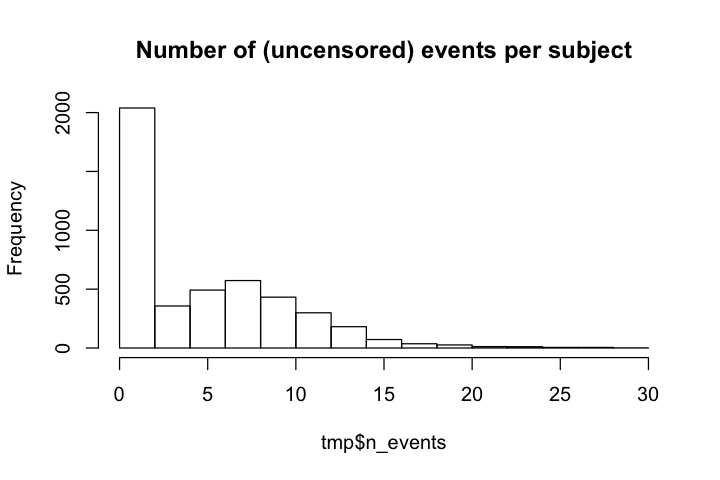

In [4]:
tmp = sel_df[,list('n_events' = max(Nm)),by = 'id']
hist(tmp$n_events, main = 'Number of (uncensored) events per subject')

# Model Choice

## Evaluate goodness of fit 
We use cross-validated mean absolute Martingale residual to choose the best model

In [6]:
set.seed(123)
#Randomly shuffle the patients
patients = sample(unique(sel_df$id))
#Create 10 equally size folds
folds <- cut(seq(1,length(patients)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement patients by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid_patients <- patients[validIndexes]
    train_patients <- patients[-validIndexes]
    # Split train, valid
    train = sel_df[id %in% train_patients]
    valid = sel_df[id %in% valid_patients]
    
    # fit
    models = list(
        coxph(Surv(start,stop,status)~ age_in + Nm + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + y + Nm:y + cluster(id), data = train),
        
        # log(Nm+1)
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + y + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + y + log(Nm+1):y + cluster(id), data = train),
        
        # log(y+1)
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + Nm + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        
        # log(Nm+1), log(y+1)
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train)
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        # evaluate martingale residuals at validation events
        valid_model = coxph(model$formula,data = valid, init = model$coefficients, iter.max = 0)
        res = residuals(valid_model, type = "martingale")
        score = mean(abs(res)) # mean absolute residual 
        fold_scores = c(fold_scores,score)
        
        # evaluate concordance probability (not correct in case of time varying coefficients!)
        #prediction = predict(model, newdata = valid)
        #score = survConcordance(Surv(start,stop,status) ~ prediction, data = valid)$concordance[[1]]
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |==============                                                        |  20%

In [7]:
# summarize CV scores
mean_scores = colMeans(scores)
best_score = min(mean_scores)
worst_score = max(mean_scores)

In [8]:
# print cv scores
print('****************** Cross validation mean absolute Martingale residual ******************')
cat('\n')
print('|------------------------|--------------------------------------|')
print('|   MEAN ABS. RESIDUAL   |               FORMULA                |')
print('|------------------------|--------------------------------------|')
for(i in 1:length(models)){
    score = mean_scores[i]
    if(score != best_score & score != worst_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3]))
    }else if (score == best_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ BEST MODEL'))
    }else{
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ WORST MODEL'))
    }
}

[1] "****************** Cross validation mean absolute Martingale residual ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|   MEAN ABS. RESIDUAL   |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        0.689           |  age_in + Nm + cluster(id)"
[1] "|        0.801           |  age_in + y + cluster(id)"
[1] "|        0.689           |  age_in + Nm + y + cluster(id)"
[1] "|        0.833           |  age_in + Nm:y + cluster(id)                  <------ WORST MODEL"
[1] "|        0.657           |  age_in + Nm + Nm:y + cluster(id)"
[1] "|        0.801           |  age_in + y + Nm:y + cluster(id)"
[1] "|        0.625           |  age_in + Nm + y + Nm:y + cluster(id)"
[1] "|        0.565           |  age_in + log(Nm + 1) + cluster(id)"
[1] "|        0.564           |  age_in + log(Nm + 1) + y + cluster(id)"
[1] "|        0.806           |  age_in + log(Nm + 1):y + cl

## A deeper exploration

Let's check the significance of the features.

### Original idea

Let:
- $N_i(t-) = Nm $ 
- $y_i(t-) = $ sum of past qt_prest_sum for patient $i$

Then the original idea was to fit a model of the form: 

$h(t|x_i) = \lambda_0(t)\times \alpha^{N_i(t-)*y_i(t-)}\times e^{\beta*age_i}$

In [9]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm:y + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm:y + cluster(id), 
    data = sel_df)

             coef  exp(coef)   se(coef)  robust se      z        p
age_in -7.797e-03  9.922e-01  5.706e-04  1.109e-03 -7.031 2.05e-12
Nm:y    8.785e-05  1.000e+00  1.247e-06  5.454e-06 16.107  < 2e-16

Likelihood ratio test=3198  on 2 df, p=< 2.2e-16
n= 26395, number of events= 21854 

For this model, we notice that all the coefficients are significative, but the **cross validation score is the worst**.

### Full model

Let's consider the "full model", i.e.:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{N_i(t-)}\times \alpha_2^{y_i(t-)} \alpha_3^{N_i(t-)y_i(t-)} \times e^{\beta*age_i}$

In [13]:
model = coxph(Surv(start,stop,status)~ age_in +  Nm + y +  Nm:y + cluster(id), data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + Nm + y + 
    Nm:y + cluster(id), data = sel_df)

             coef  exp(coef)   se(coef)  robust se       z        p
age_in -3.378e-03  9.966e-01  5.781e-04  6.110e-04  -5.529 3.22e-08
Nm      2.797e-01  1.323e+00  3.259e-03  8.817e-03  31.719  < 2e-16
y       1.489e-03  1.001e+00  4.661e-05  7.089e-05  21.007  < 2e-16
Nm:y   -1.990e-04  9.998e-01  4.980e-06  1.039e-05 -19.151  < 2e-16

Likelihood ratio test=11915  on 4 df, p=< 2.2e-16
n= 26395, number of events= 21854 

### Full model - log transformation

Let's consider the **BEST MODEL** in terms of CV score: "full model" with log transformation, i.e.:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{log(N_i(t-)+1)}\times \alpha_2^{log(y_i(t-)+1)} \alpha_3^{log(N_i(t-)+1)log(y_i(t-)+1)} \times e^{\beta*age_i}$

In [16]:
model = coxph(Surv(start,stop,status)~ age_in + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id),data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + log(Nm + 
    1) + log(y + 1) + log(Nm + 1):log(y + 1) + cluster(id), data = sel_df)

                             coef  exp(coef)   se(coef)  robust se      z
age_in                 -0.0032777  0.9967277  0.0005779  0.0005509  -5.95
log(Nm + 1)             1.5088578  4.5215634  0.0466252  0.0421203  35.82
log(y + 1)              0.0985679  1.1035893  0.0078057  0.0076430  12.90
log(Nm + 1):log(y + 1) -0.0898151  0.9141002  0.0063425  0.0064922 -13.83
                              p
age_in                 2.68e-09
log(Nm + 1)             < 2e-16
log(y + 1)              < 2e-16
log(Nm + 1):log(y + 1)  < 2e-16

Likelihood ratio test=14537  on 4 df, p=< 2.2e-16
n= 26395, number of events= 21854 

# Fit model

We decided to keep the **BEST MODEL** in terms of CV score: "full model" with log transformation, i.e.:

$h(t|x_i) = \lambda_0(t)\times \alpha_1^{log(N_i(t-)+1)}\times \alpha_2^{log(y_i(t-)+1)} \alpha_3^{log(N_i(t-)+1)log(y_i(t-)+1)} \times e^{\beta*age_i}$

In [4]:
# in order to use some function in the following cells, we build features corresponding to the transformed variables
sel_df[,'log1p_NM':=log(Nm+1)]
sel_df[,'log1p_y':=log(y+1)]
sel_df[,'log1p_NM_times_log1p_y':= log(Nm+1)*log(y+1)]

In [5]:
model = coxph(Surv(start,stop,status)~ age_in + log1p_NM + log1p_y + log1p_NM_times_log1p_y + cluster(id),data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ age_in + log1p_NM + 
    log1p_y + log1p_NM_times_log1p_y + cluster(id), data = sel_df)

                             coef  exp(coef)   se(coef)  robust se      z
age_in                 -0.0032777  0.9967277  0.0005779  0.0005509  -5.95
log1p_NM                1.5088578  4.5215634  0.0466252  0.0421203  35.82
log1p_y                 0.0985679  1.1035893  0.0078057  0.0076430  12.90
log1p_NM_times_log1p_y -0.0898151  0.9141002  0.0063425  0.0064922 -13.83
                              p
age_in                 2.68e-09
log1p_NM                < 2e-16
log1p_y                 < 2e-16
log1p_NM_times_log1p_y  < 2e-16

Likelihood ratio test=14537  on 4 df, p=< 2.2e-16
n= 26395, number of events= 21854 

In [6]:
alpha1 = exp(model$coefficients['log1p_NM'])
alpha2 = exp(model$coefficients['log1p_y'])
alpha3 = exp(model$coefficients['log1p_NM_times_log1p_y'])
beta = model$coefficients['age_in']

print(paste('alpha_1:',alpha1))
print(paste('alpha_2:',alpha2))
print(paste('alpha_3:',alpha3))
print(paste('beta:',beta))

[1] "alpha_1: 4.52156343654012"
[1] "alpha_2: 1.10358930750542"
[1] "alpha_3: 0.914100158340672"
[1] "beta: -0.00327767504056523"


We notice that:
- $\alpha_1 > 1$ : More pharmacological purchases cause more purchases in the future
- $\alpha_2 > 1$ : More days of drugs coverage cause more purchases in the future
- $\alpha_3 < 1$ : More pharmacological purchases with few days of drugs coverage cause a bigger increase in purchases than in the case with many days of drugs coverage (and vice versa). This could be a "discount" factor for regular patients.

Interestingly, $\beta < 0$. This means that older patients have less drugs purchases than the younger (but maybe more consistent?)

# Compute and smooth baseline Hazards

In [7]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [8]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,-0.5,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


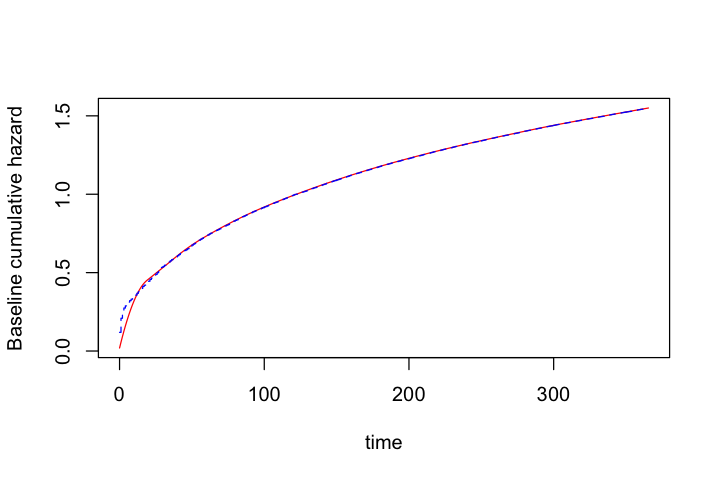

In [9]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

# Reconstruct patients cumulative Hazards

In [25]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


In [26]:
head(cumulative_hazard)

id,time,cumhaz
10000243,0,4.910391e-14
10000243,1,3.160029e-02
10000243,2,6.180080e-02
10000243,3,9.060153e-02
10000243,4,1.180025e-01
10000243,5,1.440037e-01


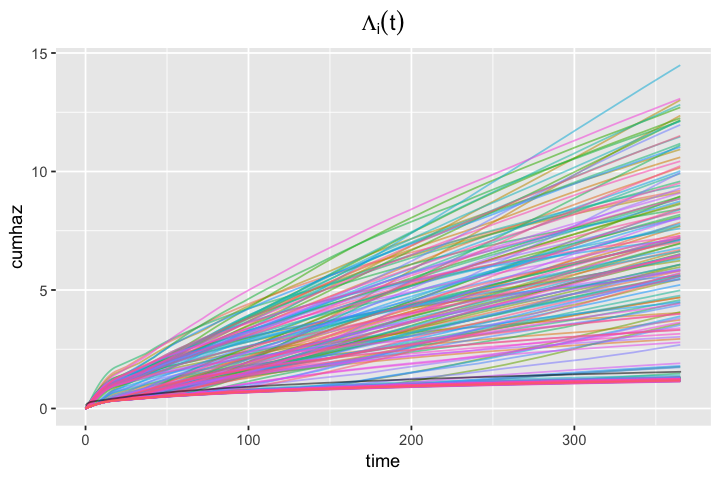

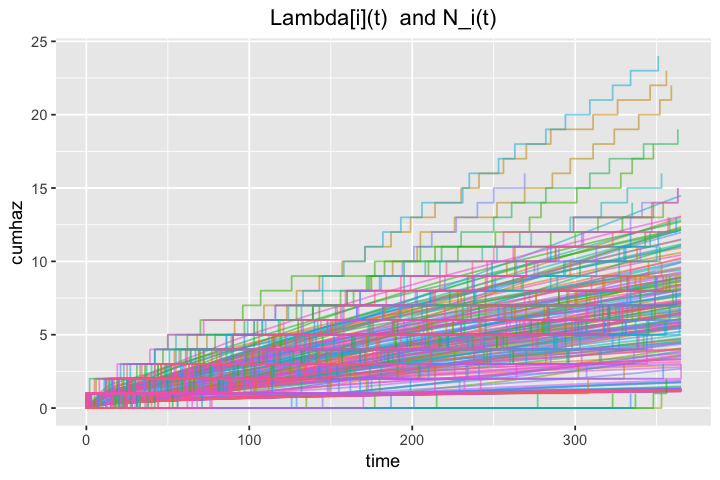

In [27]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),200)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_line(data = bh, aes(x= time, y=hazard), color = 'black') +
    ggtitle(expression(Lambda[i](t))) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [28]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards_ACE.RData')

In [1]:
load('../../data/cumulative_hazards_ACE.RData')

# Check Martingale residuals

In [30]:
# compute dataset of daily realizations (only once)
#source('compute_daily_realizations.R')
#daily_realizations_ACE = compute_daily_realizations(sel_df)
#save(daily_realizations_ACE, file = '../../data/daily_realizations_ACE.RData')

In [31]:
# load dataset of daily realizations 
load('../../data/daily_realizations_ACE.RData')
daily_realizations = daily_realizations_ACE

In [32]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

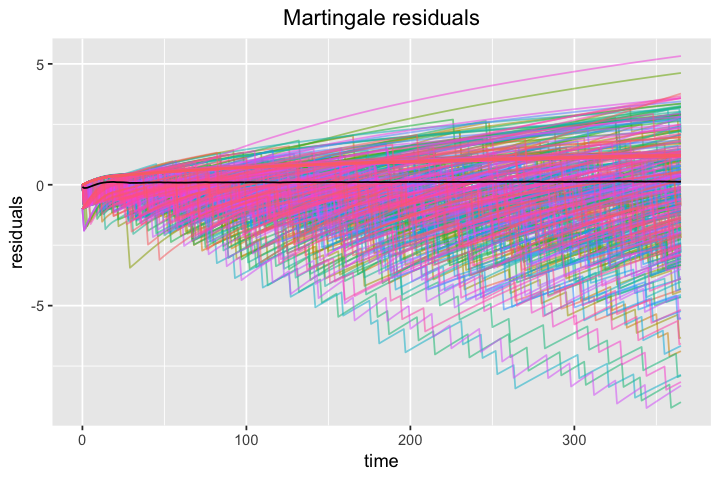

In [34]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    ggtitle('Martingale residuals') +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

The average of the residuals is approximately 0